# Risco de Abertura de Reclamação na Jornada do Totem

**Objetivo:**  
Identificar clientes com propensão a abrir reclamação após interação no Totem e fornecer o motivo do risco.

**Escopo:**  
- Definição de janela de atribuição entre interação no Totem e abertura da reclamação  
- Criação de variável resposta (target binário)  
- Construção de ABT (Totem + CRM)  
- Modelagem (XGBoost / Random Forest)  
- Explicabilidade (Reason Codes por registro)  
- Definição de thresholds e diretrizes de monitoramento


## Roadmap do Notebook

1. **Setup & Configurações iniciais**  
2. **Sprint 1 – Discovery & Definição do Target**  
   - 1.1 Estudo de Atribuição (curva de tempo entre Totem e Reclamação)  
   - 1.2 Definição da variável resposta (target binário)  
3. **Sprint 2 – Engenharia de Dados & ABT (Totem + CRM)**  
   - 2.1 Features de histórico de reclamações  
   - 2.2 Enriquecimento com CRM (perfil, risco, sentimento, canal)  
   - 2.3 Seleção de features para modelagem  
4. **Sprint 3 – Modelagem (XGBoost / Random Forest)**  
   - 3.1 Criação do mês de referência  
   - 3.2 Split Out-of-Time (Treino x Teste)  
   - 3.3 Treinamento e avaliação do modelo  
5. **Sprint 3 – Explicabilidade (XAI & Reason Codes)**  
   - 4.1 SHAP para importância por registro  
   - 4.2 Geração de Reason Codes (texto explicativo)  
6. **Sprint 4 – Thresholds & Monitoramento**  
   - 5.1 Análise de thresholds  
   - 5.2 Esqueleto de monitoramento do modelo


## 1. Setup & Configurações Iniciais

Nesta seção configuramos:
- Imports de bibliotecas
- Parâmetros do projeto (janela de atribuição, nomes de colunas)
- Caminhos de leitura das bases (Totem, Reclamações, CRM)

> Ajuste os caminhos e nomes de colunas conforme a sua realidade de dados.

--- Estatísticas de Latência (Dias) ---
count    1000.00000
mean        2.91700
std         3.33995
min         0.00000
50%         2.00000
75%         4.00000
80%         5.00000
90%         8.00000
95%        10.00000
max        20.00000
Name: dias_ate_reclamar, dtype: float64

> Sugestão de Corte (Cobre 90% dos casos): 8 dias
> Sua régua atual: 20 dias


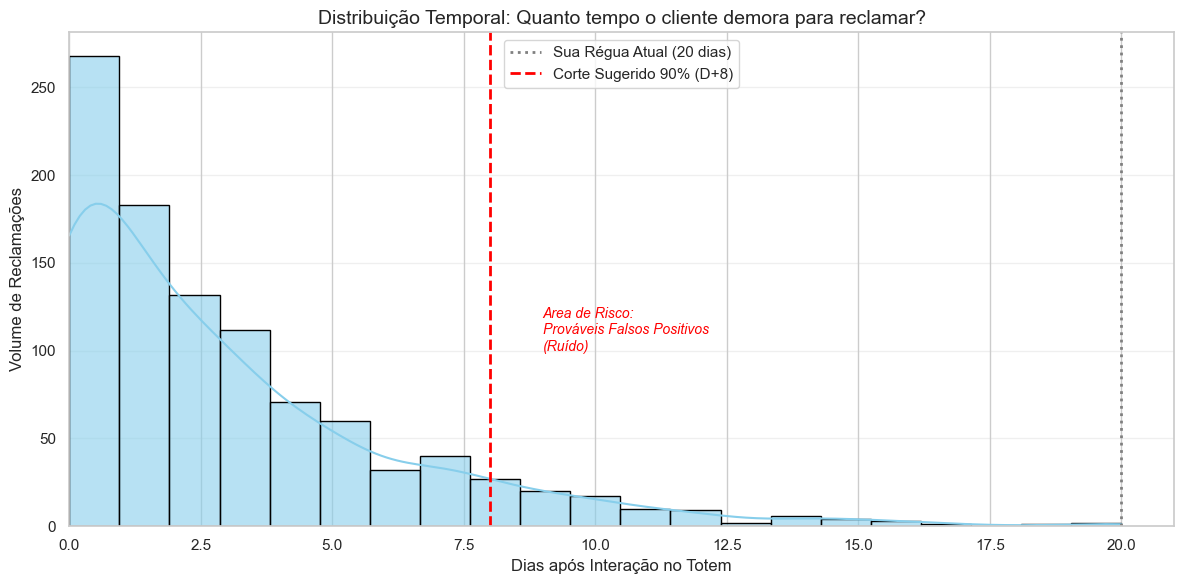

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. GERANDO DADOS FICTÍCIOS (df_reclamacoes)
# ==========================================
np.random.seed(42) # Para garantir que o gráfico seja sempre igual

# Simulando 1000 reclamações
n_records = 1000

# Gerando uma distribuição exponencial (realista para atendimento)
# A maioria dos valores será baixa (0, 1, 2 dias), com uma cauda longa até 20
# scale=3.5 controla o "decaimento" da curva
dias = np.random.exponential(scale=3.5, size=n_records).astype(int)

# Forçando o limite de 20 dias (sua regra atual)
dias = np.clip(dias, 0, 20)

df_reclamacoes = pd.DataFrame({
    'id_reclamacao': range(1, n_records + 1),
    'dias_ate_reclamar': dias,
    'assunto': np.random.choice(
        ['Numerário', 'Cartão Retido', 'Divergência', 'Tarifa', 'Outros'], 
        n_records
    )
})

# ==========================================
# 2. ANÁLISE ESTATÍSTICA (DECISÃO DO CORTE)
# ==========================================
print("--- Estatísticas de Latência (Dias) ---")
# Calculando os percentis chave
stats = df_reclamacoes['dias_ate_reclamar'].describe(percentiles=[0.5, 0.75, 0.80, 0.90, 0.95])
print(stats)

# Pegando o valor que representa 90% dos casos (Corte Sugerido)
corte_sugerido = int(stats['90%'])
print(f"\n> Sugestão de Corte (Cobre 90% dos casos): {corte_sugerido} dias")
print(f"> Sua régua atual: 20 dias")

# ==========================================
# 3. VISUALIZAÇÃO (HISTOGRAMA + COTOVELO)
# ==========================================
plt.figure(figsize=(12, 6))

# Plotando o Histograma
sns.histplot(
    data=df_reclamacoes, 
    x='dias_ate_reclamar', 
    bins=21,        # 0 a 20 dias
    kde=True,       # Linha de densidade suave
    color='skyblue',
    edgecolor='black',
    alpha=0.6
)

# Adicionando linha do seu corte ATUAL (20 dias)
plt.axvline(x=20, color='gray', linestyle=':', linewidth=2, label='Sua Régua Atual (20 dias)')

# Adicionando linha da SUGESTÃO (Ex: D+7 ou D+8 baseado nos dados gerados)
plt.axvline(x=corte_sugerido, color='red', linestyle='--', linewidth=2, label=f'Corte Sugerido 90% (D+{corte_sugerido})')

# Texto explicativo na área de "Ruído"
plt.text(
    x=corte_sugerido + 1, 
    y=100, 
    s='Area de Risco:\nProváveis Falsos Positivos\n(Ruído)', 
    color='red', 
    fontsize=10,
    style='italic'
)

# Títulos e Labels
plt.title('Distribuição Temporal: Quanto tempo o cliente demora para reclamar?', fontsize=14)
plt.xlabel('Dias após Interação no Totem', fontsize=12)
plt.ylabel('Volume de Reclamações', fontsize=12)
plt.xlim(0, 21)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# ======================
# 1. Setup & Configurações Iniciais
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# Se quiser usar XGBoost e SHAP, garanta que os pacotes estejam instalados
# !pip install xgboost shap

import xgboost as xgb
# import shap

# Configurações visuais
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

# ======================
# Parâmetros do Projeto
# ======================

# Janela de atribuição entre Interação Totem e Reclamação (em dias)
JANELA_ATRIBUICAO_DIAS = 7  # ajuste depois com base na análise da curva

# Colunas chave (ajuste para sua realidade)
COL_ID_CLIENTE = "id_cliente"
COL_DATA_INTERACAO = "data_interacao"
COL_DATA_RECLAMACAO = "data_reclamacao"

# Caminhos dos arquivos/tabelas (exemplo – ajuste para o seu ambiente)
CAMINHO_TOTEM = "dados/interacoes_totem.csv"
CAMINHO_RECLAMACOES = "dados/reclamacoes.csv"
CAMINHO_CRM = "dados/crm_clientes.csv"


## 2. Carregamento dos Dados

Aqui carregamos as bases principais:
- Interações no Totem  
- Reclamações  
- CRM (perfil, risco, sentimento, etc.)  

> Certifique-se de que as colunas de data sejam lidas como `datetime`.

In [28]:
# ======================
# 2. Carregamento dos Dados
# ======================

df_totem = pd.read_csv(CAMINHO_TOTEM, parse_dates=[COL_DATA_INTERACAO])
df_reclamacoes = pd.read_csv(CAMINHO_RECLAMACOES, parse_dates=[COL_DATA_RECLAMACAO])
df_crm = pd.read_csv(CAMINHO_CRM)  # se tiver data de referência, pode parsear também

print("Totem:")
display(df_totem.head())

print("Reclamações:")
display(df_reclamacoes.head())

print("CRM:")
display(df_crm.head())


Totem:


,id_interacao,id_cliente,data_interacao
0,1,C0001,2024-04-24
1,2,C0001,2024-06-19
2,4,C0002,2024-04-02
3,6,C0002,2024-04-05
4,3,C0002,2024-04-25


Reclamações:


,id_cliente,data_reclamacao
0,C0002,2024-06-27
1,C0005,2024-06-18
2,C0008,2024-04-16
3,C0009,2024-03-06
4,C0011,2024-03-26


CRM:


,id_cliente,idade,renda,segmento,churn_risk,nps,score_satisfacao,tempo_de_relacionamento,canal_preferencial
0,C0001,69,1860.0,PJ,0.183,7,5,21,App
1,C0002,41,9322.0,Varejo,0.021,1,4,158,Telefone
2,C0003,55,3433.0,Varejo,0.182,4,1,204,Agência
3,C0004,75,7396.0,Varejo,0.432,0,3,59,App
4,C0005,59,19431.0,PJ,0.292,2,4,55,App


## 3. Sprint 1 – Discovery & Definição do Target

### 3.1 Estudo de Atribuição (Curva de Tempo)

Objetivo: entender a distribuição do tempo entre **interação no Totem** e **abertura de reclamação**.
A partir dessa curva, definiremos a janela de atribuição `JANELA_ATRIBUICAO_DIAS`.

Passos:
1. Ordenar interações de Totem e reclamações por cliente e data  
2. Para cada reclamação, buscar a interação de Totem mais recente **antes** da reclamação  
3. Calcular o delta de dias entre interação e reclamação  
4. Analisar a distribuição dessa diferença


In [29]:
# ======================
# 3.1 Estudo de Atribuição - Curva de Tempo (sem merge_asof)
# ======================

# Cópias para não alterar os dataframes originais
df_totem_aux = df_totem.copy()
df_recl_aux = df_reclamacoes.copy()

# Garante que as colunas de data estejam no formato datetime
df_totem_aux[COL_DATA_INTERACAO] = pd.to_datetime(df_totem_aux[COL_DATA_INTERACAO])
df_recl_aux[COL_DATA_RECLAMACAO] = pd.to_datetime(df_recl_aux[COL_DATA_RECLAMACAO])

# Garante que o ID do cliente tenha o MESMO tipo nas duas bases
df_totem_aux[COL_ID_CLIENTE] = df_totem_aux[COL_ID_CLIENTE].astype(str)
df_recl_aux[COL_ID_CLIENTE] = df_recl_aux[COL_ID_CLIENTE].astype(str)

# Combina todas as reclamações com todas as interações de Totem do mesmo cliente
df_attr = df_recl_aux[[COL_ID_CLIENTE, COL_DATA_RECLAMACAO]].merge(
    df_totem_aux[[COL_ID_CLIENTE, COL_DATA_INTERACAO]],
    on=COL_ID_CLIENTE,
    how="left"
)

# Calcula diferença em dias entre reclamação e interação no Totem
df_attr["delta_dias"] = (
    df_attr[COL_DATA_RECLAMACAO] - df_attr[COL_DATA_INTERACAO]
).dt.days

# Mantém apenas interações que ocorreram antes (ou no mesmo dia) da reclamação
df_attr = df_attr[df_attr["delta_dias"].notna() & (df_attr["delta_dias"] >= 0)]

# Para cada reclamação, pega a interação de Totem mais próxima (menor delta_dias)
idx_min = df_attr.groupby([COL_ID_CLIENTE, COL_DATA_RECLAMACAO])["delta_dias"].idxmin()
df_attr = df_attr.loc[idx_min].reset_index(drop=True)

df_attr["delta_dias"].describe()


count    107.000000
mean       4.682243
std        3.109930
min        0.000000
25%        2.000000
50%        4.000000
75%        7.500000
max       10.000000
Name: delta_dias, dtype: float64

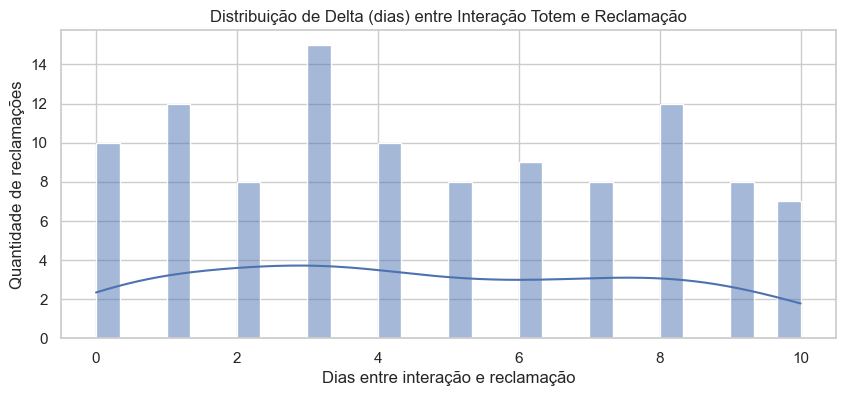

In [30]:
# Visualização da curva de tempo
plt.figure(figsize=(10,4))
sns.histplot(df_attr["delta_dias"], bins=30, kde=True)
plt.title("Distribuição de Delta (dias) entre Interação Totem e Reclamação")
plt.xlabel("Dias entre interação e reclamação")
plt.ylabel("Quantidade de reclamações")
plt.show()


### 3.2 Definição da Variável Resposta (Target Binário)

Definição do target por interação no Totem:
- `target = 1` se o cliente abriu uma reclamação em até `JANELA_ATRIBUICAO_DIAS` após a interação.  
- `target = 0` caso contrário.

Passos:
1. Para cada interação, buscar a **primeira reclamação após a interação**  
2. Calcular o delta de dias  
3. Marcar target=1 quando o delta está entre 0 e `JANELA_ATRIBUICAO_DIAS`


In [31]:
# ======================
# 3.2 Definição do Target Binário (versão sem merge_asof)
# ======================

# Cópias para não alterar os dataframes originais
df_totem_aux = df_totem.copy()
df_recl_aux = df_reclamacoes.copy()

# Garante tipos consistentes
df_totem_aux[COL_DATA_INTERACAO] = pd.to_datetime(df_totem_aux[COL_DATA_INTERACAO])
df_recl_aux[COL_DATA_RECLAMACAO] = pd.to_datetime(df_recl_aux[COL_DATA_RECLAMACAO])

df_totem_aux[COL_ID_CLIENTE] = df_totem_aux[COL_ID_CLIENTE].astype(str)
df_recl_aux[COL_ID_CLIENTE] = df_recl_aux[COL_ID_CLIENTE].astype(str)

# Mantém apenas colunas relevantes de reclamações
df_recl_simpl = df_recl_aux[[COL_ID_CLIENTE, COL_DATA_RECLAMACAO]].copy()

# 1) Combina cada interação no Totem com todas as reclamações do mesmo cliente
df_tmp = df_totem_aux[[COL_ID_CLIENTE, COL_DATA_INTERACAO]].merge(
    df_recl_simpl,
    on=COL_ID_CLIENTE,
    how="left"
)

# 2) Calcula o delta entre interação e reclamação
df_tmp["delta_dias"] = (df_tmp[COL_DATA_RECLAMACAO] - df_tmp[COL_DATA_INTERACAO]).dt.days

# 3) Mantém apenas reclamações APÓS a interação (delta >= 0)
df_tmp_valid = df_tmp[df_tmp["delta_dias"].notna() & (df_tmp["delta_dias"] >= 0)].copy()

# 4) Para cada interação (cliente + data_interacao), pega a reclamação mais próxima (menor delta_dias)
idx_min = df_tmp_valid.groupby([COL_ID_CLIENTE, COL_DATA_INTERACAO])["delta_dias"].idxmin()
df_min = df_tmp_valid.loc[idx_min, [COL_ID_CLIENTE, COL_DATA_INTERACAO, COL_DATA_RECLAMACAO, "delta_dias"]]

# 5) Faz um left merge com TODAS as interações de Totem, para manter interações sem reclamação
df_label = df_totem_aux.merge(
    df_min,
    on=[COL_ID_CLIENTE, COL_DATA_INTERACAO],
    how="left"
)

# 6) Define o target:
#    1 se há reclamação na janela [0, JANELA_ATRIBUICAO_DIAS]; caso contrário, 0
df_label["target"] = np.where(
    (df_label["delta_dias"].notna()) &
    (df_label["delta_dias"] >= 0) &
    (df_label["delta_dias"] <= JANELA_ATRIBUICAO_DIAS),
    1,
    0
)

df_label[[COL_ID_CLIENTE, COL_DATA_INTERACAO, COL_DATA_RECLAMACAO, "delta_dias", "target"]].head()

,id_cliente,data_interacao,data_reclamacao,delta_dias,target
0,C0001,2024-04-24,NaT,NaN,0
1,C0001,2024-06-19,NaT,NaN,0
2,C0002,2024-04-02,2024-06-27,86.0,0
3,C0002,2024-04-05,2024-06-27,83.0,0
4,C0002,2024-04-25,2024-06-27,63.0,0


## 4. Sprint 2 – Engenharia de Dados & ABT (Totem + CRM)

Objetivo: construir uma **Analytical Base Table (ABT)** que una a visão de Totem (interações) com CRM (perfil, risco, sentimento, histórico, canal).

Componentes principais:
- Histórico de reclamações anteriores  
- Perfil (idade, renda, segmento)  
- Risco (churn_risk)  
- Sentimento (NPS, score_satisfacao)  
- Histórico e tempo de relacionamento  
- Canal preferencial


### 4.1 Histórico de Reclamações (qtd_reclamacoes_anteriores)

Aqui criamos uma variável simplificada de **quantidade de reclamações anteriores** por cliente.
Você pode refinar para janelas específicas (ex.: últimos 12 meses) se necessário.

In [32]:
# ======================
# 4.1 Histórico de Reclamações (qtd_reclamacoes_anteriores)
# ======================

df_recl_hist = df_reclamacoes.copy()
df_recl_hist["qtd_reclamacoes_total"] = 1

# Agrega por cliente
df_recl_hist_agg = (
    df_recl_hist
    .groupby(COL_ID_CLIENTE)["qtd_reclamacoes_total"]
    .sum()
    .reset_index()
)

df_recl_hist_agg.rename(columns={"qtd_reclamacoes_total": "qtd_reclamacoes_anteriores"}, inplace=True)

df_recl_hist_agg.head()


,id_cliente,qtd_reclamacoes_anteriores
0,C0002,1
1,C0005,1
2,C0008,1
3,C0009,1
4,C0011,1


### 4.2 Enriquecimento com CRM

Assumimos que o CRM possui, ao menos, as seguintes colunas:
- `idade`  
- `renda`  
- `segmento`  
- `churn_risk`  
- `nps`  
- `score_satisfacao`  
- `tempo_de_relacionamento`  
- `canal_preferencial`  

> Adapte os nomes conforme a estrutura do seu CRM.

In [33]:
# ======================
# 4.2 Enriquecimento com CRM
# ======================

# Faz merge da base label (por interação no totem) com CRM
df_abt = df_label.merge(df_crm, on=COL_ID_CLIENTE, how="left")

# Adiciona histórico de reclamações anteriores
df_abt = df_abt.merge(df_recl_hist_agg, on=COL_ID_CLIENTE, how="left")

# Preenche faltas com 0 para quantidade de reclamações anteriores
df_abt["qtd_reclamacoes_anteriores"] = df_abt["qtd_reclamacoes_anteriores"].fillna(0)

df_abt.head()


,id_interacao,id_cliente,data_interacao,data_reclamacao,delta_dias,target,idade,renda,segmento,churn_risk,nps,score_satisfacao,tempo_de_relacionamento,canal_preferencial,qtd_reclamacoes_anteriores
0,1,C0001,2024-04-24,NaT,NaN,0,69,1860.0,PJ,0.183,7,5,21,App,0.0
1,2,C0001,2024-06-19,NaT,NaN,0,69,1860.0,PJ,0.183,7,5,21,App,0.0
2,4,C0002,2024-04-02,2024-06-27,86.0,0,41,9322.0,Varejo,0.021,1,4,158,Telefone,1.0
3,6,C0002,2024-04-05,2024-06-27,83.0,0,41,9322.0,Varejo,0.021,1,4,158,Telefone,1.0
4,3,C0002,2024-04-25,2024-06-27,63.0,0,41,9322.0,Varejo,0.021,1,4,158,Telefone,1.0


### 4.3 Seleção de Features para Modelagem

Vamos separar as variáveis em numéricas e categóricas e gerar **dummies** para as categóricas.

Exemplos de features numéricas:
- idade, renda, churn_risk, nps, score_satisfacao, tempo_de_relacionamento, qtd_reclamacoes_anteriores

Exemplos de features categóricas:
- segmento, canal_preferencial


In [34]:
# ======================
# 4.3 Seleção de Features Numéricas e Categóricas
# ======================

# Exemplo de lista de features (ajuste conforme colunas existentes)
features_numericas = [
    "idade",
    "renda",
    "churn_risk",
    "nps",
    "score_satisfacao",
    "tempo_de_relacionamento",
    "qtd_reclamacoes_anteriores"
]

features_categoricas = [
    "segmento",
    "canal_preferencial"
    # se tiver mais, inclua aqui
]

# Cria dummies para as categóricas
df_model = df_abt.copy()

df_model = pd.get_dummies(
    df_model,
    columns=features_categoricas,
    drop_first=True
)

# Target
col_target = "target"

# Define colunas de features (exclui colunas não preditivas)
colunas_excluir = [
    col_target,
    COL_ID_CLIENTE,
    COL_DATA_INTERACAO,
    COL_DATA_RECLAMACAO,
    "delta_dias"
]

feature_cols = [col for col in df_model.columns if col not in colunas_excluir]

X = df_model[feature_cols].fillna(0)
y = df_model[col_target]

X.head()


,id_interacao,idade,renda,churn_risk,nps,score_satisfacao,tempo_de_relacionamento,qtd_reclamacoes_anteriores,segmento_Prime,segmento_Varejo,canal_preferencial_App,canal_preferencial_Internet Banking,canal_preferencial_Telefone
0,1,69,1860.0,0.183,7,5,21,0.0,False,False,True,False,False
1,2,69,1860.0,0.183,7,5,21,0.0,False,False,True,False,False
2,4,41,9322.0,0.021,1,4,158,1.0,False,True,False,False,True
3,6,41,9322.0,0.021,1,4,158,1.0,False,True,False,False,True
4,3,41,9322.0,0.021,1,4,158,1.0,False,True,False,False,True


## 5. Sprint 3 – Modelagem (XGBoost / Random Forest)

Vamos treinar um modelo de classificação com foco em dados tabulares (XGBoost ou Random Forest) usando **validação Out-of-Time (OOT)**.

Passos:
1. Criar um campo de mês de referência a partir da data de interação  
2. Definir meses de treino (M-3 a M-1) e mês de teste (M)  
3. Treinar o modelo e avaliar AUC e curva ROC


### 5.1 Criação do Mês de Referência

Criamos `mes_referencia` a partir de `data_interacao` para facilitar o split Out-of-Time.

In [35]:
# ======================
# 5.1 Criação do Mês de Referência
# ======================

df_model["mes_referencia"] = df_abt[COL_DATA_INTERACAO].dt.to_period("M").astype(str)
df_model[["mes_referencia", COL_DATA_INTERACAO]].head()


,mes_referencia,data_interacao
0,2024-04,2024-04-24
1,2024-06,2024-06-19
2,2024-04,2024-04-02
3,2024-04,2024-04-05
4,2024-04,2024-04-25


### 5.2 Definição de Períodos (Treino vs Teste - Out-of-Time)

Aqui escolhemos um mês de teste (Mês atual) e usamos os meses anteriores como treino.

> **Importante:** Ajuste a variável `MES_TESTE` conforme os dados disponíveis.

In [36]:
# ======================
# 5.2 Definição de Períodos (Treino vs Teste - Out-of-Time)
# ======================

# Ver meses disponíveis
print(df_model["mes_referencia"].value_counts().sort_index())

# Defina manualmente o mês de teste (exemplo: '2024-06')
MES_TESTE = "2024-06"  # <-- ajuste para o mês que você quer usar como "mês atual"

# Meses de treino = todos os meses anteriores ao MES_TESTE
meses_treino = sorted(df_model["mes_referencia"].unique())
meses_treino = [m for m in meses_treino if m < MES_TESTE]

print("Meses de treino:", meses_treino)
print("Mês de teste:", MES_TESTE)

mask_treino = df_model["mes_referencia"].isin(meses_treino)
mask_teste = df_model["mes_referencia"] == MES_TESTE

X_train = X[mask_treino]
y_train = y[mask_treino]

X_test = X[mask_teste]
y_test = y[mask_teste]

X_train.shape, X_test.shape


mes_referencia
2024-03    146
2024-04    159
2024-05    127
2024-06    163
Name: count, dtype: int64
Meses de treino: ['2024-03', '2024-04', '2024-05']
Mês de teste: 2024-06


((432, 13), (163, 13))

### 5.3 Treinamento do Modelo (XGBoost)

Treinamos um `XGBClassifier` para estimar o score de propensão (0 a 1). Em seguida, avaliamos o desempenho via AUC e curva ROC.

In [37]:
# ======================
# 5.3 Treinamento - XGBoost
# ======================

model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
)

model_xgb.fit(X_train, y_train)

# Predições
y_train_pred_proba = model_xgb.predict_proba(X_train)[:, 1]
y_test_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"AUC Treino: {auc_train:.4f}")
print(f"AUC Teste (OOT): {auc_test:.4f}")


AUC Treino: 0.9655
AUC Teste (OOT): 0.7552


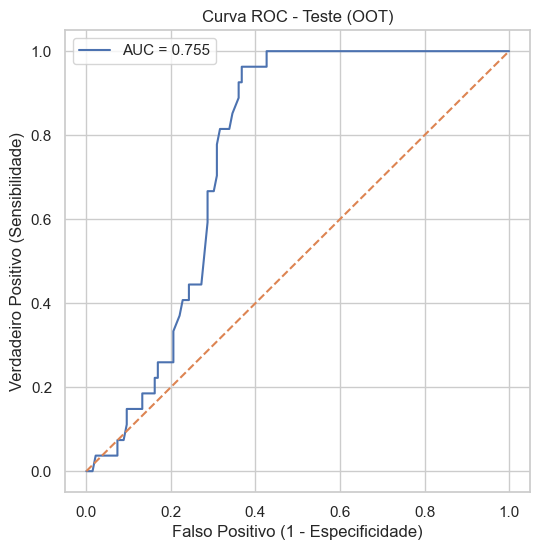

In [38]:
# Curva ROC no teste
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC - Teste (OOT)")
plt.legend()
plt.show()


> **Opcional:** Você pode testar também um `RandomForestClassifier` como baseline, trocando a célula de treinamento.

In [39]:
# Exemplo opcional: RandomForest em vez de XGBoost
# descomente para usar

# model_rf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=8,
#     random_state=42,
#     n_jobs=-1
# )
# 
# model_rf.fit(X_train, y_train)
# y_test_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]
# auc_test_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
# print(f"AUC Teste (RF): {auc_test_rf:.4f}")


## 6. Sprint 3 – Explicabilidade (XAI) & Reason Codes

Agora vamos gerar explicações por registro usando SHAP:
- Para cada interação, teremos um **score de propensão**  
- E um **texto explicativo** (Reason Codes) destacando as variáveis que mais contribuíram para o score

Formato esperado de saída (exemplo):
`Score: 0.85 | Motivo: qtd_reclamacoes_anteriores: 4 | idade: 75 | nps: 3`

### 6.1 Explicabilidade com SHAP (TreeExplainer)

Usamos `TreeExplainer` para o modelo XGBoost, obtendo o impacto de cada feature por observação.

In [ ]:
# # ======================
# # 6.1 Explicabilidade com SHAP (TreeExplainer)
# # ======================

# # Cria o explicador para o modelo XGBoost
# explainer = shap.TreeExplainer(model_xgb)

# # Para grandes volumes de dados, pode ser interessante pegar apenas uma amostra
# shap_values = explainer.shap_values(X_test)

# # shap_values tem o mesmo shape de X_test
# shap_values.shape


In [44]:
# ======================
# 6.1 Importâncias Globais das Features (sem SHAP)
# ======================

# Importâncias das features do modelo XGBoost
feature_names = X_test.columns.tolist()
feature_importances = model_xgb.feature_importances_

importances_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

importances_df.head(10)

,feature,importance
7,qtd_reclamacoes_anteriores,0.376267
3,churn_risk,0.070666
9,segmento_Varejo,0.058328
5,score_satisfacao,0.056252
2,renda,0.055068
10,canal_preferencial_App,0.052884
6,tempo_de_relacionamento,0.049973
1,idade,0.049960
8,segmento_Prime,0.049206
11,canal_preferencial_Internet Banking,0.049136


In [46]:
# ======================
# 6.2 Função para Reason Codes (usando importância global)
# ======================

import numpy as np

def gerar_reason_codes(valores_features, feature_names, importancias, top_k=3):
    """
    Gera texto com as top_k variáveis mais relevantes para o score,
    usando a importância global * valor da feature como proxy de contribuição.
    Formato: "feature1: valor | feature2: valor | ..."
    """
    valores_features = np.array(valores_features, dtype=float)
    importancias = np.array(importancias, dtype=float)

    # "Força" da feature = |valor * importância|
    contrib = np.abs(valores_features * importancias)

    # Índices ordenados por contribuição (maior -> menor)
    idx_sorted = np.argsort(contrib)[::-1][:top_k]

    parts = []
    for idx in idx_sorted:
        nome = feature_names[idx]
        valor = valores_features[idx]
        # arredonda valor numérico
        valor_fmt = f"{valor:.2f}"
        parts.append(f"{nome}: {valor_fmt}")

    return " | ".join(parts)


In [47]:
# ======================
# 6.3 Tabela Final com Score de Propensão e Reason Codes (sem SHAP)
# ======================

# Base de teste alinhada
df_test = df_abt[mask_teste].copy()
df_test = df_test.reset_index(drop=True)

# Garante alinhamento com X_test
X_test_reset = X_test.reset_index(drop=True)

scores = y_test_pred_proba

reason_codes_list = []
for i in range(len(X_test_reset)):
    valores_features = X_test_reset.iloc[i].values
    rc = gerar_reason_codes(
        valores_features=valores_features,
        feature_names=feature_names,
        importancias=feature_importances,
        top_k=3
    )
    reason_codes_list.append(rc)

df_scoring = pd.DataFrame({
    "id_interacao": df_test.get("id_interacao", df_test.index),
    COL_ID_CLIENTE: df_test[COL_ID_CLIENTE],
    COL_DATA_INTERACAO: df_test[COL_DATA_INTERACAO],
    "score_propensao": scores,
    "reason_codes": reason_codes_list,
    "target_real": df_test["target"]
})

df_scoring.head()


,id_interacao,id_cliente,data_interacao,score_propensao,reason_codes,target_real
0,2,C0001,2024-06-19,0.001855,renda: 1860.00 | idade: 69.00 | tempo_de_relac...,0
1,7,C0002,2024-06-19,0.015133,renda: 9322.00 | tempo_de_relacionamento: 158....,0
2,5,C0002,2024-06-30,0.015133,renda: 9322.00 | tempo_de_relacionamento: 158....,0
3,9,C0003,2024-06-07,0.005418,renda: 3433.00 | tempo_de_relacionamento: 204....,0
4,11,C0003,2024-06-15,0.005418,renda: 3433.00 | tempo_de_relacionamento: 204....,0


### 6.2 Função para Reason Codes

Função utilitária para gerar o texto com as **top K variáveis** que mais influenciaram o score para cada cliente.

In [48]:
# ======================
# 6.2 Função para Reason Codes
# ======================

feature_names = X_test.columns.tolist()

def gerar_reason_codes(valores_features, shap_row, feature_names, top_k=3):
    """Gera texto com as top_k variáveis mais importantes (em valor absoluto de SHAP).
    Formato: "feature1: valor | feature2: valor | ..."""
    shap_abs = np.abs(shap_row)
    idx_sorted = np.argsort(shap_abs)[::-1][:top_k]
    
    parts = []
    for idx in idx_sorted:
        nome = feature_names[idx]
        valor = valores_features[idx]
        # arredonda valor numérico (se for numérico)
        if isinstance(valor, (int, float, np.number)):
            valor_fmt = f"{valor:.2f}"
        else:
            valor_fmt = str(valor)
        parts.append(f"{nome}: {valor_fmt}")
    
    return " | ".join(parts)


### 6.3 Tabela Final com Score de Propensão e Reason Codes

Aqui construímos a tabela consolidada com:
- Identificador da interação / cliente  
- Data da interação  
- Score de propensão  
- Reason Codes  
- Target real (para avaliação)

In [ ]:
# ======================
# 6.3 Tabela Final com Score de Propensão e Reason Codes
# ======================

# Recupera a base de teste alinhada
df_test = df_abt[mask_teste].copy()
df_test = df_test.reset_index(drop=True)

# Garante que X_test esteja alinhado com df_test
X_test_reset = X_test.reset_index(drop=True)
shap_values_array = np.array(shap_values)

scores = y_test_pred_proba

reason_codes_list = []
for i in range(len(X_test_reset)):
    valores_features = X_test_reset.iloc[i].values
    shap_row = shap_values_array[i]
    rc = gerar_reason_codes(valores_features, shap_row, feature_names, top_k=3)
    reason_codes_list.append(rc)

df_scoring = pd.DataFrame({
    "id_interacao": df_test.get("id_interacao", df_test.index),
    COL_ID_CLIENTE: df_test[COL_ID_CLIENTE],
    COL_DATA_INTERACAO: df_test[COL_DATA_INTERACAO],
    "score_propensao": scores,
    "reason_codes": reason_codes_list,
    "target_real": df_test["target"]
})

df_scoring.head()


IndexError: index 13 is out of bounds for axis 0 with size 13

## 7. Sprint 4 – Thresholds & Monitoramento

Nesta etapa definimos pontos de corte (thresholds) para transformar o score contínuo em **alto/baixo risco**,
e montamos um esqueleto de monitoramento de performance ao longo do tempo.

### 7.1 Análise de Thresholds

Avaliaremos métricas de classificação (precision, recall, TP, FP, etc.) para diferentes thresholds.
Isso auxilia a escolher um ponto de corte alinhado à estratégia de negócio (ex.: volume máximo de acionamento).

In [ ]:
# ======================
# 7.1 Análise de Thresholds
# ======================

def avaliar_threshold(y_true, y_score, thresholds):
    linhas = []
    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        linhas.append({
            "threshold": thr,
            "precision": precision,
            "recall": recall,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn
        })
    return pd.DataFrame(linhas)

thresholds_testados = np.arange(0.1, 0.91, 0.1)
df_thr = avaliar_threshold(y_test, y_test_pred_proba, thresholds_testados)
df_thr


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df_thr["threshold"], df_thr["precision"], marker="o", label="Precision")
plt.plot(df_thr["threshold"], df_thr["recall"], marker="o", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Métrica")
plt.title("Precision x Recall por Threshold")
plt.legend()
plt.show()


Com base nessa tabela/gráfico, defina um ponto de corte operacional, considerando trade-offs entre
quantidade de clientes acionados e qualidade da priorização.

In [ ]:
# Exemplo de escolha de threshold operacional
THRESHOLD_OPERACIONAL = 0.7  # ajuste baseado na análise acima

df_scoring["flag_alto_risco"] = (df_scoring["score_propensao"] >= THRESHOLD_OPERACIONAL).astype(int)
df_scoring.head()


### 7.2 Monitoramento do Modelo (Esqueleto)

Sugestões de monitoramento contínuo:
- AUC ao longo dos meses  
- Distribuição de scores (drift)  
- Volume de alto risco vs reclamações reais (backtest mensal)


In [ ]:
# ======================
# 7.2 Monitoramento - Esqueleto
# ======================

def auc_por_mes(df_model, X, y, model, col_mes="mes_referencia"):
    resultados = []
    for mes in sorted(df_model[col_mes].unique()):
        mask = df_model[col_mes] == mes
        if mask.sum() < 50:  # mínimo de linhas para considerar
            continue
        X_m = X[mask]
        y_m = y[mask]
        score_m = model.predict_proba(X_m)[:,1]
        auc_m = roc_auc_score(y_m, score_m)
        resultados.append({"mes_referencia": mes, "auc": auc_m})
    return pd.DataFrame(resultados)

df_auc_mes = auc_por_mes(df_model, X, y, model_xgb, col_mes="mes_referencia")
df_auc_mes


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_auc_mes["mes_referencia"], df_auc_mes["auc"], marker="o")
plt.xticks(rotation=45)
plt.xlabel("Mês de Referência")
plt.ylabel("AUC")
plt.title("Evolução da AUC por Mês (Monitoramento)")
plt.tight_layout()
plt.show()


## 8. Conclusões e Próximos Passos

Neste notebook, implementamos o roadmap para o projeto de **Risco de Abertura de Reclamação na Jornada do Totem**:

- Definimos uma janela de atribuição e construímos o **target binário** por interação.  
- Montamos uma **ABT** unificando Totem + CRM, incluindo perfil, risco, sentimento e histórico.  
- Treinamos um modelo de classificação (XGBoost) com **validação Out-of-Time**.  
- Implementamos um módulo de **Explicabilidade (Reason Codes)** por cliente.  
- Propusemos uma análise de **thresholds** e um esqueleto de **monitoramento contínuo**.

Próximos passos práticos:
- Validar com o time de negócio os thresholds e o formato dos Reason Codes.  
- Integrar esse pipeline em ambiente de produção (batch ou online).  
- Incluir novas features (por exemplo, jornada multicanal, recorrência de uso do Totem, etc.) e reavaliar o modelo periodicamente.
